# Enoncé
## Contexte
**Mon rôle** : data scientist

**Commanditaire** : Prêt à dépenser

**Activité de l'entreprise :** société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt

**Projet :** mettre en œuvre un outil de “scoring crédit”

**Type de Mission :** classification binaire déséquilibrée

## Attendus
**But de la mission :** classifie la demande en crédit accordé ou refusé en s’appuyant sur des sources de données variées 

**Base de données :** https://www.kaggle.com/c/home-credit-default-risk/data (données comportementales, données provenant d'autres institutions financières, ...)

**Etapes demandées :**
1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
==> les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit

**Détails de la mission :** 
Le dashboard interactif devra contenir au minimum les fonctionnalités suivantes :
- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

**Livrables demandés :** 
- **Le dashboard interactif répondant aux spécifications ci-dessus et l’API de prédiction du score, déployées chacunes sur le cloud.**
- Un dossier sur un outil de versioning de code contenant :
    - Le code de la modélisation (du prétraitement à la prédiction)
    - Le code générant le dashboard
    - Le code permettant de déployer le modèle sous forme d'API
- Une note méthodologique décrivant :
    - La méthodologie d'entraînement du modèle (2 pages maximum)
    - La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
    - L’interprétabilité globale et locale du modèle (1 page maximum)
    - Les limites et les améliorations possibles (1 page maximum)
- Un support de présentation pour la soutenance, détaillant le travail réalisé.

# Librairies et paramétrages
## Mise à jour des librairies

In [1]:
'''
import re
import pip
listLib = !pip list --outdated --format freeze
listLib = list(listLib)
listLib = [re.sub('(\=)+(.)+$', '', i) for i in listLib]
pip.main(['install'] + listLib + ['--upgrade'] + ['--user'])
'''

"\nimport re\nimport pip\nlistLib = !pip list --outdated --format freeze\nlistLib = list(listLib)\nlistLib = [re.sub('(\\=)+(.)+$', '', i) for i in listLib]\npip.main(['install'] + listLib + ['--upgrade'] + ['--user'])\n"

## Importations des librairies

In [2]:
# Gestion des données
import pandas as pd
import numpy as np

# Gestion des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Métrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer

# Modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Exportation des objets
import pickle 
import dill
import gzip
import bz2
from os.path import dirname, join, realpath

# Echantillonnage
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Validation Croisée
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve 
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Transformation
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import make_pipeline

# Interpretability
from lime.lime_tabular import LimeTabularExplainer

import math
import ast
import random
import json


# Système
from copy import deepcopy
import os
import re
import time
import warnings
warnings.filterwarnings("ignore")
'''
'''

'\n'

## Paramétrages

In [3]:
# Format des résultats affichés
pd.set_option('display.max_columns', None) # display.max_columns : contrôle le nombre de colonnes à imprimer (int ou None pour imprimer toutes les colonnes)
pd.set_option('max_colwidth', None) # Vous pouvez augmenter la largeur en passant un int (ou mettre au max en passant None)
pd.set_option("display.max_rows", None) # Pour modifier le nombre de lignes, vous devez modifier l' option max_rows 
pd.options.display.float_format = '{:.4f}'.format # enlève le format d'affichage : nombre scientifique

# Pour afficher les graphiques dans la continuité du code, et non pas dans une fenêtre à part:
%matplotlib inline

## Importation des données

In [4]:
print("Téléchargement du fichier...")
df = pd.read_csv('data_train.csv')

Téléchargement du fichier...


In [5]:
print("Fichier de {:,} lignes et {} colonnes.".format(df.shape[0], df.shape[1]).replace(',',''))

Fichier de 307507 lignes et 760 colonnes.


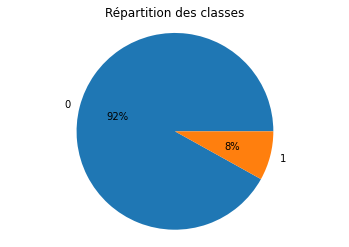

In [6]:
df['TARGET'].value_counts(normalize = True).plot(kind = 'pie', autopct = '%1.f%%', label = '')
plt.axis('equal') # Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.title('Répartition des classes')
plt.show();

Comme vue précédemment, les classes sont déséquilibrées.

# Modélisation
## Test des modèles basiques

In [7]:
def get_model(xtrain, ytrain, pipeline, cv, df_res = np.nan):
    
    ### Gestion de l'appel du modèle ###  
    time1 = time.time()
    listScore = ['roc_auc']
    
    cross_score = cross_validate(pipeline
                                 , xtrain
                                 , ytrain
                                 , scoring = listScore
                                 , cv = cv
                                 , n_jobs = -1
                                 , return_train_score = True
                                 )
    
    ### Ajout des résultats au dataframe ###
    dict_append = {'Modèle':pipeline.steps[-1][0]
                   ,'UnderSample':under
                   ,'OverSample':over}
    for score in listScore:
        dict_append['train_'+score] = round(np.mean(cross_score['train_'+score]),4)
        dict_append['test_'+score] = round(np.mean(cross_score['test_'+score]),4)
    
    dict_append['Time'] = time.time() - time1
    
    df_res = pd.concat([df_res,pd.DataFrame([dict_append])], ignore_index = False).reset_index(drop = True)
    
    ### Affichage de la courbe AUC ###
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    i = 0
    for train, test in cv.split(xtrain,ytrain):
        i += 1
        probas_ = pipeline.fit(xtrain.iloc[train], ytrain.iloc[train]).predict_proba(xtrain.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(ytrain.iloc[test], probas_[:, 1])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw = 1, label = 'ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color = (0.6, 0.6, 0.6), label = 'Luck')

    mean_tpr /= cv.get_n_splits(xtrain, ytrain)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw = 2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # show the legend
    plt.legend()
    
    plt.show();
    
    return df_res

In [8]:
def matrix_model(pipeline, xtrain, ytrain, xtest, ytest, threshold = "none"):
    
    pipeline.fit(xtrain, ytrain)
    if threshold == "none":
        ypred = pipeline.predict(xtest)
        print("Matrice de confusion (avec méthode predict)")
    else:
        ypred = (pipeline.predict_proba(xtest)[:,1] >= threshold).astype(bool)
        print("Matrice de confusion (avec méthode predict_proba + threshold optimisé)")
    
    # matrice de confusion
    matrix = confusion_matrix(ytest, ypred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix, annot = labels, fmt = "", cmap = 'Blues')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')
    plt.show();
    
    df_matrix = pd.DataFrame(matrix
                          , index = ['0', '1']
                          , columns = ['0', '1']
                         )
    falsePos = int(df_matrix.loc[df_matrix.index == '0','1'].values)
    falseNeg = int(df_matrix.loc[df_matrix.index == '1','0'].values)
    print(f"{falseNeg + falsePos} clients ont été incorrectement classé :")
    print(f"- {falsePos} clients \033[1m sans défaut de paiement \033[0m ont été prédit en \033[1m insolvable \033[0m")
    print(f"- {falseNeg} clients \033[1m en défaut de paiement \033[0m ont été prédit en \033[1m solvable \033[0m")
    
    #print(matrix)

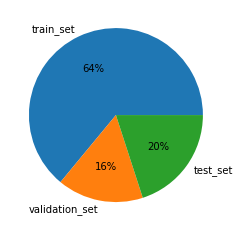

In [9]:
listVarX = df.columns.to_list()
listVarX = [x for x in listVarX if x not in ['TARGET','SK_ID_CURR']]

X = df[listVarX].copy()
y = df['TARGET'].astype(int).copy()

xtrain_all, xtest, ytrain_all, ytest = train_test_split(X
                                                        , y
                                                        , train_size = .8
                                                        , random_state = 0
                                                        , shuffle = True
                                                        , stratify = y)

xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_all
                                                  , ytrain_all
                                                  , train_size = .8
                                                  , random_state = 0
                                                  , shuffle = True
                                                  , stratify = ytrain_all)

x = [xtrain.shape[0], xvalid.shape[0], xtest.shape[0]]
plt.pie(x, labels = ['train_set', 'validation_set', 'test_set'], normalize = True, autopct = '%1.f%%')
plt.show();

In [10]:
listVarCat = []
for var in listVarX:
    if (xtrain[var].nunique() == 2) & (not var.endswith(('MIN','MAX','MEAN','VAR','SUM'))):
        listVarCat.append(var)
listVarNum = [x for x in listVarX if x not in listVarCat]
#del listVarCat

In [11]:
cv = StratifiedKFold(n_splits = 3)

numerical_pipeline = make_pipeline(StandardScaler()
                                   , SimpleImputer(missing_values = np.nan, strategy = 'mean'))
preprocessor = make_column_transformer((numerical_pipeline, listVarNum)
                                       , remainder = 'passthrough')
del numerical_pipeline

over = SMOTE()
under = RandomUnderSampler()

df_resultats = pd.DataFrame(columns = ['Modèle','UnderSample','OverSample'])

### Forêts

In [12]:
rfc = RandomForestClassifier(class_weight = 'balanced')
pipeline_rfc = make_pipeline(preprocessor, over, under, rfc)

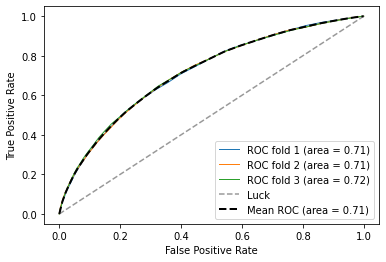

,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time
0,randomforestclassifier,RandomUnderSampler(),SMOTE(),1.0000,0.7138,401.8870


In [13]:
df_resultats = get_model(xtrain, ytrain, pipeline_rfc, cv, df_resultats)
df_resultats

Matrice de confusion (avec méthode predict)


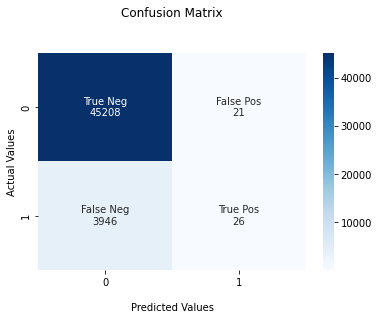

3967 clients ont été incorrectement classé :
- 21 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 3946 clients  en défaut de paiement  ont été prédit en  solvable 


In [14]:
matrix_model(pipeline_rfc, xtrain, ytrain, xvalid, yvalid)

### Régression logistique

In [15]:
rl = LogisticRegression(class_weight = "balanced")
pipeline_rl = make_pipeline(preprocessor, over, under, rl)

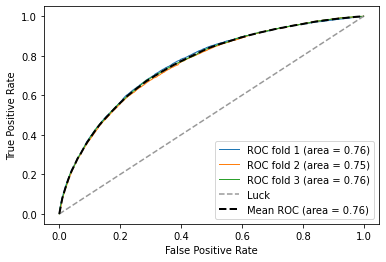

,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time
0,randomforestclassifier,RandomUnderSampler(),SMOTE(),1.0000,0.7138,401.8870
1,logisticregression,RandomUnderSampler(),SMOTE(),0.7719,0.7573,64.0885


In [16]:
df_resultats = get_model(xtrain, ytrain, pipeline_rl, cv, df_resultats)
df_resultats

Matrice de confusion (avec méthode predict)


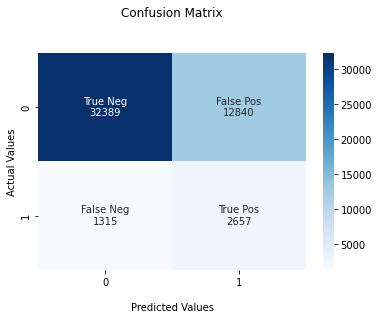

14155 clients ont été incorrectement classé :
- 12840 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 1315 clients  en défaut de paiement  ont été prédit en  solvable 


In [17]:
matrix_model(pipeline_rl, xtrain, ytrain, xvalid, yvalid)

### Ensemble Boosting

In [18]:
spw = round(float(ytrain[ytrain == 1].shape[0] / ytrain[ytrain == 0].shape[0]),4)
xgb = XGBClassifier(scale_pos_weight = spw)
pipeline_xgb = make_pipeline(preprocessor, over, under, xgb)

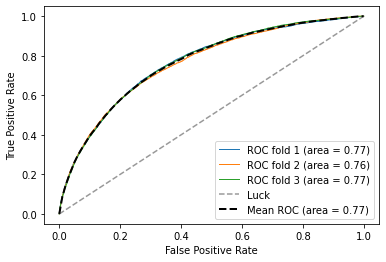

,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time
0,randomforestclassifier,RandomUnderSampler(),SMOTE(),1.0000,0.7138,401.8870
1,logisticregression,RandomUnderSampler(),SMOTE(),0.7719,0.7573,64.0885
2,xgbclassifier,RandomUnderSampler(),SMOTE(),0.8750,0.7658,1353.2223


In [19]:
df_resultats = get_model(xtrain, ytrain, pipeline_xgb, cv, df_resultats)
df_resultats

Matrice de confusion (avec méthode predict)


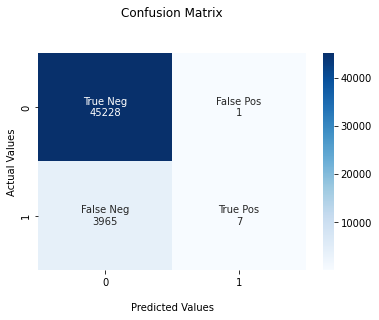

3966 clients ont été incorrectement classé :
- 1 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 3965 clients  en défaut de paiement  ont été prédit en  solvable 


In [20]:
matrix_model(pipeline_xgb, xtrain, ytrain, xvalid, yvalid)

Le meilleur modèle à l'air d'être, pour l'instant, la **régression logistique**, puisque c'est le seul modèle qui *n'overfit pas* et qui *minimise les faux négatifs*.

## Optimisation (modèle + seuil)

In [21]:
def opti_model(pipeline, x, y, df_res, params, cv, score = 'roc_auc'):
    
    xtrain, xvalid, ytrain, yvalid = train_test_split(x
                                                      , y
                                                      , train_size = .5
                                                      , random_state = 0
                                                      , shuffle = True
                                                      , stratify = y)
                            
    print('--- Grid Search CV ---')
    if not isinstance(params, dict):
        mean_best_test_score = 0
        for idx in np.arange(0,len(pipeline)):
            grid_search = BayesSearchCV(pipeline[idx]
                                        , params[idx]
                                        , n_iter = 32
                                        , cv = cv
                                        , scoring = score
                                        , n_jobs = -1
                                        , return_train_score = True
                                        , error_score = 0
                                      ) 
            grid_search.fit(xtrain, ytrain)

            if grid_search.cv_results_['mean_test_score'][grid_search.best_index_] > mean_best_test_score:
                # best score
                mean_best_train_score = grid_search.cv_results_['mean_train_score'][grid_search.best_index_]
                mean_best_test_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

                # best parameters
                dictParams = dict(grid_search.best_params_)
                
                #best pipeline
                best_pipeline = pipeline[idx].set_params(**dictParams)
                
    else:
        grid_search = BayesSearchCV(pipeline
                                    , params
                                    , n_iter = 32
                                    , cv = cv
                                    , scoring = score
                                    , n_jobs = -1
                                    , return_train_score = True
                                    , error_score = 0
                                  ) 
        grid_search.fit(xtrain, ytrain)

        # best parameters
        dictParams = dict(grid_search.best_params_)
        print()

        # best score
        mean_best_train_score = grid_search.cv_results_['mean_train_score'][grid_search.best_index_]
        mean_best_test_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]
        
        # best pipeline
        best_pipeline = pipeline.set_params(**dictParams)
        
    print('Mean cross-validated score of best params')
    print('for train score :',mean_best_train_score)
    print('for test score :',mean_best_test_score) 
    print()
    print('Best params :',dictParams)
    
    
    print()
    print()
    print('--- Optimisation du seuil ---')
    best_pipeline.fit(xtrain,ytrain)
    y_proba = best_pipeline.predict_proba(xvalid)
    # keep probabilities for the positive outcome only
    probs = y_proba[:, 1]
    # define thresholds
    thresholds = np.arange(0, 1, 0.1)
    # evaluate each threshold
    if score == 'roc_auc':
        scores = [roc_auc_score(yvalid, (probs >= t).astype('int')) for t in thresholds]
    else:
        temp = str(score).replace('make_scorer(','').replace(')','')
        name_func = temp[:temp.index(",")]
        params_func = temp[temp.index(","):].replace(', ','')
        name_param = params_func[:params_func.index("=")]
        value_param = params_func[params_func.index("="):].replace('=','')
        dict_param = {'y_true':yvalid, 'y_pred': None, name_param:int(value_param)}
        scores = []
        for t in thresholds:
            dict_param['y_pred'] = (probs >= t).astype('int')
            scores.append(globals()[name_func](**dict_param))
    
    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, Score=%.5f' % (thresholds[ix], scores[ix]))
    
    # print in df
    name_prefixe = 'OPTI_'
    if score == 'roc_auc':
        name_prefixe = name_prefixe + 'ROC_AUC'
    else:
        name_prefixe = name_prefixe + 'FBETA_SCORE'
    df_res.loc[df_res['Modèle'] == best_pipeline.steps[-1][0], name_prefixe+'_TRAIN_SCORE'] = mean_best_train_score
    df_res.loc[df_res['Modèle'] == best_pipeline.steps[-1][0], name_prefixe+'_TEST_SCORE'] = mean_best_test_score
    df_res.loc[df_res['Modèle'] == best_pipeline.steps[-1][0], name_prefixe+'_BEST_PARAMS'] = str(dictParams)
    df_res.loc[df_res['Modèle'] == best_pipeline.steps[-1][0], name_prefixe+'_SEUIL'] = thresholds[ix]
    df_res.loc[df_res['Modèle'] == best_pipeline.steps[-1][0], name_prefixe+'_SEUIL_TEST_SCORE'] = scores[ix]
    
    return df_res, best_pipeline

In [22]:
params = {'smote__sampling_strategy':Real(.1, .3) # default=’auto’
          , 'smote__k_neighbors':Integer(5,150) # default=5
          , 'randomundersampler__sampling_strategy':Real(.4, .7) # default=’auto’
         }

### Forêts

In [23]:
params_rfc = params.copy()
params_rfc['randomforestclassifier__criterion'] = Categorical(['gini', 'entropy']) # default=”gini”
params_rfc['randomforestclassifier__n_estimators'] = Integer(100, 350) # default=100
params_rfc['randomforestclassifier__max_features'] = Categorical(['auto', 'sqrt','log2']) # default=”sqrt”
params_rfc['randomforestclassifier__max_depth'] = Integer(2, 50) # default=None
params_rfc['randomforestclassifier__min_samples_split'] = Integer(15, 30) # default=2
params_rfc['randomforestclassifier__min_samples_leaf'] = Integer(25, 35) # default=1
df_resultats, pipeline_rfc_best = opti_model(pipeline_rfc, xtrain, ytrain, df_resultats, params_rfc, cv, 'roc_auc')
df_resultats.loc[df_resultats['Modèle'] == 'randomforestclassifier',:]

--- Grid Search CV ---

Mean cross-validated score of best params
for train score : 0.895938495404021
for test score : 0.7475705610250576

Best params : {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 27, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 25, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 350, 'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}


--- Optimisation du seuil ---
Threshold=0.400, Score=0.67904


,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time,OPTI_ROC_AUC_TRAIN_SCORE,OPTI_ROC_AUC_TEST_SCORE,OPTI_ROC_AUC_BEST_PARAMS,OPTI_ROC_AUC_SEUIL,OPTI_ROC_AUC_SEUIL_TEST_SCORE
0,randomforestclassifier,RandomUnderSampler(sampling_strategy=0.4),SMOTE(sampling_strategy=0.1),1.0000,0.7138,401.8870,0.8959,0.7476,"{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 27, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 25, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 350, 'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}",0.4000,0.6790


Matrice de confusion (avec méthode predict)


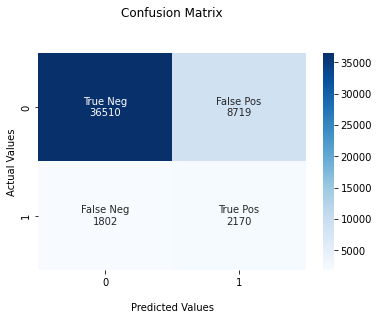

10521 clients ont été incorrectement classé :
- 8719 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 1802 clients  en défaut de paiement  ont été prédit en  solvable 


In [24]:
matrix_model(pipeline_rfc_best, xtrain, ytrain, xvalid, yvalid)

### Régression logistique

In [25]:
pipeline_rl_1 = deepcopy(pipeline_rl)
pipeline_rl_1.set_params(logisticregression__penalty = "l1")
params_rl1 = params.copy()
params_rl1['logisticregression__C'] = Real(1, 10, 'log-uniform') # default=1.0
params_rl1['logisticregression__fit_intercept'] = Categorical([True, False]) # default=True
params_rl1['logisticregression__solver'] = Categorical(['liblinear', 'saga']) # default=’lbfgs’

In [26]:
pipeline_rl_2 = deepcopy(pipeline_rl)
pipeline_rl_2.set_params(logisticregression__penalty = "l2")
params_rl2 = params.copy()
params_rl2['logisticregression__C'] = Real(1, 10, 'log-uniform') # default=1.0
params_rl2['logisticregression__fit_intercept'] = Categorical([True, False]) # default=True
params_rl2['logisticregression__solver'] = Categorical(['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']) # default=’lbfgs’

In [27]:
pipeline_rl_3 = deepcopy(pipeline_rl)
pipeline_rl_3.set_params(logisticregression__penalty = "elasticnet", logisticregression__solver = 'saga')
params_rl3 = params.copy()
params_rl3['logisticregression__C'] = Real(1, 10, 'log-uniform') # default=1.0
params_rl3['logisticregression__fit_intercept'] = Categorical([True, False]) # default=True
params_rl3['logisticregression__l1_ratio'] = Real(.1, .9, 'log-uniform') # default=None

In [28]:
pipeline_rl_4 = deepcopy(pipeline_rl)
pipeline_rl_4.set_params(logisticregression__penalty = "none")
params_rl4 = params.copy()
params_rl4['logisticregression__C'] = Real(1, 10, 'log-uniform') # default=1.0
params_rl4['logisticregression__fit_intercept'] = Categorical([True, False]) # default=True
params_rl4['logisticregression__solver'] = Categorical(['lbfgs', 'newton-cg', 'sag', 'saga']) # default=’lbfgs’

In [29]:
list_pipeline_rl = [pipeline_rl_1, pipeline_rl_2, pipeline_rl_3, pipeline_rl_4]
params_rl = [params_rl1, params_rl2, params_rl3, params_rl4]

In [30]:
df_resultats, pipeline_rl_best = opti_model(list_pipeline_rl, xtrain, ytrain, df_resultats, params_rl, cv, 'roc_auc')
df_resultats.loc[df_resultats['Modèle'] == 'logisticregression',:]

--- Grid Search CV ---
Mean cross-validated score of best params
for train score : 0.7785750198503237
for test score : 0.7630275120152571

Best params : {'logisticregression__C': 1.0, 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga', 'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}


--- Optimisation du seuil ---
Threshold=0.500, Score=0.69658


,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time,OPTI_ROC_AUC_TRAIN_SCORE,OPTI_ROC_AUC_TEST_SCORE,OPTI_ROC_AUC_BEST_PARAMS,OPTI_ROC_AUC_SEUIL,OPTI_ROC_AUC_SEUIL_TEST_SCORE
1,logisticregression,RandomUnderSampler(sampling_strategy=0.4),SMOTE(sampling_strategy=0.1),0.7719,0.7573,64.0885,0.7786,0.7630,"{'logisticregression__C': 1.0, 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga', 'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}",0.5000,0.6966


Matrice de confusion (avec méthode predict)


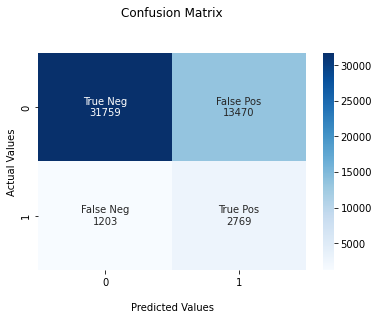

14673 clients ont été incorrectement classé :
- 13470 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 1203 clients  en défaut de paiement  ont été prédit en  solvable 


In [31]:
matrix_model(pipeline_rl_best, xtrain, ytrain, xvalid, yvalid)

### Ensemble Boosting

In [32]:
params_xgb = params.copy()
params_xgb['xgbclassifier__n_estimators'] = Integer(60,220) # default = 100
params_xgb['xgbclassifier__learning_rate'] = Real(.1, 1, 'log-uniform') # default None
params_xgb['xgbclassifier__max_depth'] = Integer(2, 50) # default None
df_resultats, pipeline_xgb_best = opti_model(pipeline_xgb, xtrain, ytrain, df_resultats, params_xgb, cv, 'roc_auc')
df_resultats.loc[df_resultats['Modèle'] == 'xgbclassifier',:]

--- Grid Search CV ---

Mean cross-validated score of best params
for train score : 0.7924059657005683
for test score : 0.7704793467584267

Best params : {'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 150, 'smote__sampling_strategy': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 220}


--- Optimisation du seuil ---
Threshold=0.100, Score=0.59671


,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time,OPTI_ROC_AUC_TRAIN_SCORE,OPTI_ROC_AUC_TEST_SCORE,OPTI_ROC_AUC_BEST_PARAMS,OPTI_ROC_AUC_SEUIL,OPTI_ROC_AUC_SEUIL_TEST_SCORE
2,xgbclassifier,RandomUnderSampler(sampling_strategy=0.4),"SMOTE(k_neighbors=150, sampling_strategy=0.1)",0.8750,0.7658,1353.2223,0.7924,0.7705,"{'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 150, 'smote__sampling_strategy': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 220}",0.1000,0.5967


Matrice de confusion (avec méthode predict)


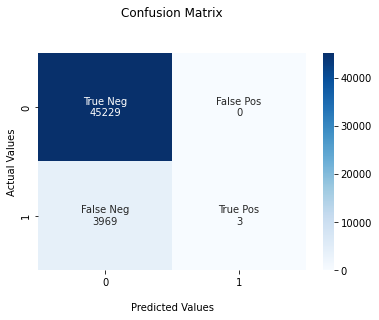

3969 clients ont été incorrectement classé :
- 0 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 3969 clients  en défaut de paiement  ont été prédit en  solvable 


In [33]:
matrix_model(pipeline_xgb_best, xtrain, ytrain, xvalid, yvalid)

## Adaptation du modèle à la nouvelle fonction de coût (métier)

Il est attendu de mettre en œuvre une approche simple qui consiste, une fois le modèle choisi et les hyperparamètres optimisés finement d’un point de vue technique via l’AUC (CF étape précédente), de calculer une fonction de coût métier de type 10*FN + FP (où FN = nombre de FN dans la matrice de confusion pour un seuil donné, FP = nombre de FP) et de trouver son minimum pour un seuil donné.
Une possibilité de fonction métier adaptée au projet est la fonction fbeta_score de sklearn, qui permet d’attribuer plus de poids à la minimisation des FN à travers la pondération du paramètre beta.
Il est recommandé d’effectuer une nouvelle recherche des hyper-paramètres se basant sur la fonction métier proposée, de cette façon, ils seront choisis de sorte à minimiser la perte pour l’entreprise.
D’autres approches plus complexes seraient de remonter cette mesure de calcul de coût métier (avec optimisation du seuil) dans la simulation fine du modèle final choisi, voire pour tous les modèles (cette mesure remplacerait l’AUC).

F-measure fournit un score unique qui résume la précision et le rappel.
Fbeta-measure fournit une version configurable (beta) de la F-measure pour accorder plus ou moins d'attention à la mesure de précision et de rappel lors du calcul d'un seul score.

Une valeur bêta par défaut est 1. Une valeur bêta plus petite, telle que 0.5, donne plus de poids à la précision et moins au rappel, tandis qu'une valeur bêta plus grande, telle que 2, donne moins de poids à la précision et plus de poids au rappel dans le calcul du score. Le but ici est de minimiser les faux négatifs (étant donné que la maximisation du rappel minimisera les erreurs de faux négatifs), il faut donc donner plus de poids au rappel et ainsi donner un paramètre beta > 1.

Source : https://machinelearningmastery.com/fbeta-measure-for-machine-learning/

In [34]:
ftwo_scorer = make_scorer(fbeta_score, beta = 2)

### Fôrets

In [35]:
df_resultats, pipeline_rfc_best = opti_model(pipeline_rfc, xtrain, ytrain, df_resultats, params_rfc, cv, ftwo_scorer)
df_resultats.loc[df_resultats['Modèle'] == 'randomforestclassifier',:]

--- Grid Search CV ---

Mean cross-validated score of best params
for train score : 0.5011690856569406
for test score : 0.4077808736049478

Best params : {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 45, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 35, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 350, 'randomundersampler__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}


--- Optimisation du seuil ---
Threshold=0.500, Score=0.40909


,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time,OPTI_ROC_AUC_TRAIN_SCORE,OPTI_ROC_AUC_TEST_SCORE,OPTI_ROC_AUC_BEST_PARAMS,OPTI_ROC_AUC_SEUIL,OPTI_ROC_AUC_SEUIL_TEST_SCORE,OPTI_FBETA_SCORE_TRAIN_SCORE,OPTI_FBETA_SCORE_TEST_SCORE,OPTI_FBETA_SCORE_BEST_PARAMS,OPTI_FBETA_SCORE_SEUIL,OPTI_FBETA_SCORE_SEUIL_TEST_SCORE
0,randomforestclassifier,RandomUnderSampler(sampling_strategy=0.7),SMOTE(sampling_strategy=0.1),1.0000,0.7138,401.8870,0.8959,0.7476,"{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 27, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 25, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 350, 'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}",0.4000,0.6790,0.5012,0.4078,"{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 45, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 35, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 350, 'randomundersampler__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}",0.5000,0.4091


Matrice de confusion (avec méthode predict)


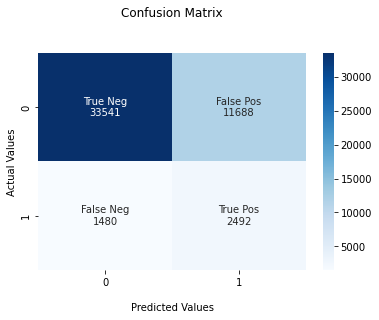

13168 clients ont été incorrectement classé :
- 11688 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 1480 clients  en défaut de paiement  ont été prédit en  solvable 


In [36]:
matrix_model(pipeline_rfc_best, xtrain, ytrain, xvalid, yvalid)

### Régression logistique

In [37]:
df_resultats, pipeline_rl_best = opti_model(list_pipeline_rl, xtrain, ytrain, df_resultats, params_rl, cv, ftwo_scorer)
df_resultats.loc[df_resultats['Modèle'] == 'logisticregression',:]

--- Grid Search CV ---
Mean cross-validated score of best params
for train score : 0.4387708118580675
for test score : 0.4282105864436801

Best params : {'logisticregression__C': 1.0, 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga', 'randomundersampler__sampling_strategy': 0.608447560164542, 'smote__k_neighbors': 33, 'smote__sampling_strategy': 0.1}


--- Optimisation du seuil ---
Threshold=0.500, Score=0.42877


,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time,OPTI_ROC_AUC_TRAIN_SCORE,OPTI_ROC_AUC_TEST_SCORE,OPTI_ROC_AUC_BEST_PARAMS,OPTI_ROC_AUC_SEUIL,OPTI_ROC_AUC_SEUIL_TEST_SCORE,OPTI_FBETA_SCORE_TRAIN_SCORE,OPTI_FBETA_SCORE_TEST_SCORE,OPTI_FBETA_SCORE_BEST_PARAMS,OPTI_FBETA_SCORE_SEUIL,OPTI_FBETA_SCORE_SEUIL_TEST_SCORE
1,logisticregression,RandomUnderSampler(sampling_strategy=0.7),SMOTE(sampling_strategy=0.1),0.7719,0.7573,64.0885,0.7786,0.7630,"{'logisticregression__C': 1.0, 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga', 'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}",0.5000,0.6966,0.4388,0.4282,"{'logisticregression__C': 1.0, 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga', 'randomundersampler__sampling_strategy': 0.608447560164542, 'smote__k_neighbors': 33, 'smote__sampling_strategy': 0.1}",0.5000,0.4288


Matrice de confusion (avec méthode predict)


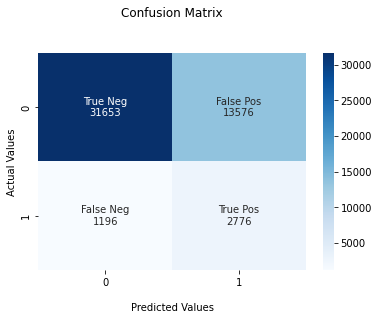

14772 clients ont été incorrectement classé :
- 13576 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 1196 clients  en défaut de paiement  ont été prédit en  solvable 


In [38]:
matrix_model(pipeline_rl_best, xtrain, ytrain, xvalid, yvalid)

### Ensemble Boosting

In [39]:
df_resultats, pipeline_xgb_best = opti_model(pipeline_xgb, xtrain, ytrain, df_resultats, params_xgb, cv, ftwo_scorer)
df_resultats.loc[df_resultats['Modèle'] == 'xgbclassifier',:]

--- Grid Search CV ---

Mean cross-validated score of best params
for train score : 0.7777377741234607
for test score : 0.34880642508768006

Best params : {'randomundersampler__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1, 'xgbclassifier__learning_rate': 1.0, 'xgbclassifier__max_depth': 43, 'xgbclassifier__n_estimators': 220}


--- Optimisation du seuil ---
Threshold=0.100, Score=0.39581


,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time,OPTI_ROC_AUC_TRAIN_SCORE,OPTI_ROC_AUC_TEST_SCORE,OPTI_ROC_AUC_BEST_PARAMS,OPTI_ROC_AUC_SEUIL,OPTI_ROC_AUC_SEUIL_TEST_SCORE,OPTI_FBETA_SCORE_TRAIN_SCORE,OPTI_FBETA_SCORE_TEST_SCORE,OPTI_FBETA_SCORE_BEST_PARAMS,OPTI_FBETA_SCORE_SEUIL,OPTI_FBETA_SCORE_SEUIL_TEST_SCORE
2,xgbclassifier,RandomUnderSampler(sampling_strategy=0.7),SMOTE(sampling_strategy=0.1),0.8750,0.7658,1353.2223,0.7924,0.7705,"{'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 150, 'smote__sampling_strategy': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 220}",0.1000,0.5967,0.7777,0.3488,"{'randomundersampler__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1, 'xgbclassifier__learning_rate': 1.0, 'xgbclassifier__max_depth': 43, 'xgbclassifier__n_estimators': 220}",0.1000,0.3958


Matrice de confusion (avec méthode predict)


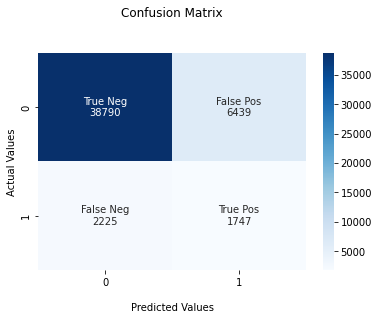

8664 clients ont été incorrectement classé :
- 6439 clients  sans défaut de paiement  ont été prédit en  insolvable 
- 2225 clients  en défaut de paiement  ont été prédit en  solvable 


In [40]:
matrix_model(pipeline_xgb_best, xtrain, ytrain, xvalid, yvalid)

In [41]:
df_resultats

,Modèle,UnderSample,OverSample,train_roc_auc,test_roc_auc,Time,OPTI_ROC_AUC_TRAIN_SCORE,OPTI_ROC_AUC_TEST_SCORE,OPTI_ROC_AUC_BEST_PARAMS,OPTI_ROC_AUC_SEUIL,OPTI_ROC_AUC_SEUIL_TEST_SCORE,OPTI_FBETA_SCORE_TRAIN_SCORE,OPTI_FBETA_SCORE_TEST_SCORE,OPTI_FBETA_SCORE_BEST_PARAMS,OPTI_FBETA_SCORE_SEUIL,OPTI_FBETA_SCORE_SEUIL_TEST_SCORE
0,randomforestclassifier,RandomUnderSampler(sampling_strategy=0.7),SMOTE(sampling_strategy=0.1),1.0000,0.7138,401.8870,0.8959,0.7476,"{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 27, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 25, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 350, 'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}",0.4000,0.6790,0.5012,0.4078,"{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 45, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 35, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 350, 'randomundersampler__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}",0.5000,0.4091
1,logisticregression,RandomUnderSampler(sampling_strategy=0.7),SMOTE(sampling_strategy=0.1),0.7719,0.7573,64.0885,0.7786,0.7630,"{'logisticregression__C': 1.0, 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga', 'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1}",0.5000,0.6966,0.4388,0.4282,"{'logisticregression__C': 1.0, 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga', 'randomundersampler__sampling_strategy': 0.608447560164542, 'smote__k_neighbors': 33, 'smote__sampling_strategy': 0.1}",0.5000,0.4288
2,xgbclassifier,RandomUnderSampler(sampling_strategy=0.7),SMOTE(sampling_strategy=0.1),0.8750,0.7658,1353.2223,0.7924,0.7705,"{'randomundersampler__sampling_strategy': 0.4, 'smote__k_neighbors': 150, 'smote__sampling_strategy': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 220}",0.1000,0.5967,0.7777,0.3488,"{'randomundersampler__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.1, 'xgbclassifier__learning_rate': 1.0, 'xgbclassifier__max_depth': 43, 'xgbclassifier__n_estimators': 220}",0.1000,0.3958


In [42]:
pipeline_best = pipeline_rl_best
threshold_best = .5

## Interprétation du modèle
### Globale explanation : Features importances

In [155]:
pipeline_best = model
threshold_best = .5

In [156]:
# entrainement du meilleur modèle sur toute la partie train (train + valid)
pipeline_best = pipeline_best.fit(xtrain_all,ytrain_all)

In [157]:
# prediction sur la partie test
yprob = pipeline_best.predict_proba(xtest)[:, 1]
ypred = (yprob >= threshold_best).astype('int')
# score vie réelle
print('--- Scores vie réelle ---')
print('Score fbeta :',round(fbeta_score(ytest, ypred, beta = 2),2))
print('Score roc auc :',round(roc_auc_score(ytest, ypred),2))

--- Scores vie réelle ---
Score fbeta : 0.43
Score roc auc : 0.7


In [158]:
def get_importance(pipeline, type_func = 'feature_importance'):
    if type_func == 'feature_importance':
        # RandomForestClassifier OU XGB
        importance = pipeline.steps[-1][1].feature_importances_
    elif type_func == 'coef':
        # LogisticRegression
        importance = pipeline.steps[-1][1].coef_[0] # [0]: valeur absolu pour filtrer sur les plus importantes
    else:
        importance = None
        print('Error, put an available name of func for the feature importance. Ex. : feature_importance OR coef.')
    
    return importance

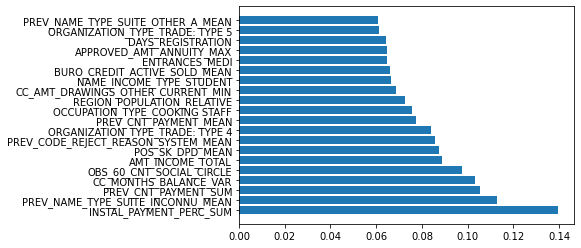

Il y a 345 variables utilisées par le modèle.


In [159]:
df_coefs = pd.DataFrame(get_importance(pipeline_best, 'coef')
                        , columns = ["Coefficients"]
                        , index = pipeline_best.feature_names_in_
                       )
df_coefs = df_coefs[df_coefs['Coefficients'] > 0]

df_barh = df_coefs.sort_values('Coefficients', ascending = False).head(20)

plt.barh(df_barh.index, df_barh['Coefficients'])
plt.show();

print(f'Il y a {df_coefs.shape[0]} variables utilisées par le modèle.')

--- Scores vie réelle ---
Score fbeta : 0.4
Score roc auc : 0.67


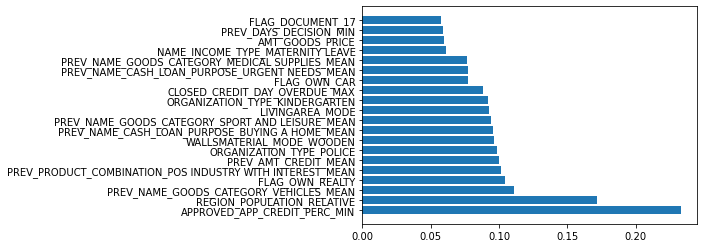

In [160]:
# dict_opti = json.loads(df_resultats.loc[df_resultats['Modèle'] == 'logisticregression', 'OPTI_FBETA_SCORE_BEST_PARAMS'])
dict_opti = {'logisticregression__C': 1.0, 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga', 'randomundersampler__sampling_strategy': 0.608447560164542, 'smote__k_neighbors': 33, 'smote__sampling_strategy': 0.1}
listVarKeep = df_coefs.index.tolist()
listVarKeepNum = [x for x in listVarKeep if x in listVarNum]
listVarKeepCat = [x for x in listVarKeep if x not in listVarKeepNum]
numerical_pipeline = make_pipeline(StandardScaler()
                                   , SimpleImputer(missing_values = np.nan, strategy = 'mean'))
preprocessor = make_column_transformer((numerical_pipeline, listVarKeepNum)
                                       , ('passthrough', listVarKeepCat)
                                      )
#del numerical_pipeline, listVarKeepNum
over = SMOTE()
under = RandomUnderSampler()
pipeline_final = make_pipeline(preprocessor, over, under, LogisticRegression(class_weight = "balanced"))
#del preprocessor, over, under
pipeline_final = pipeline_final.set_params(**dict_opti)
pipeline_final = pipeline_final.fit(xtrain_all[listVarKeep],ytrain_all)
# prediction sur la partie test
yprob_temp = pipeline_final.predict_proba(xtest[listVarKeep])[:, 1]
ypred_temp = (yprob_temp >= threshold_best).astype('int')
# score vie réelle
print('--- Scores vie réelle ---')
print('Score fbeta :',round(fbeta_score(ytest, ypred_temp, beta = 2),2))
print('Score roc auc :',round(roc_auc_score(ytest, ypred_temp),2))

df_coefs = pd.DataFrame(get_importance(pipeline_final, 'coef')
                        , columns = ["Coefficients"]
                        , index = pipeline_final.feature_names_in_
                       )

df_barh = df_coefs.sort_values('Coefficients', ascending = False).head(20)

plt.barh(df_barh.index, df_barh['Coefficients'])
plt.show();

### Importances locales : Lime explainer

In [161]:
xtrain_data = pipeline_final.steps[0][1].transform(xtrain[listVarKeep])
class_names = list(ytrain.unique())
explainer = LimeTabularExplainer(xtrain_data
                                  , mode = "classification"
                                  , class_names = class_names
                                  , feature_names = listVarKeep
                                  , categorical_features = listVarKeepCat
                                 )

In [162]:
idx_sample = random.randrange(0, len(xtest))

xtest_transform = pipeline_final.steps[0][1].transform(xtest[listVarKeep])
xtest_transform_random = xtest_transform[idx_sample]
obj_proba = pipeline_final.steps[-1][1].predict_proba

exp = explainer.explain_instance(xtest_transform_random
                                 , obj_proba
                                 , num_features = 20
                                )
del xtest_transform, obj_proba

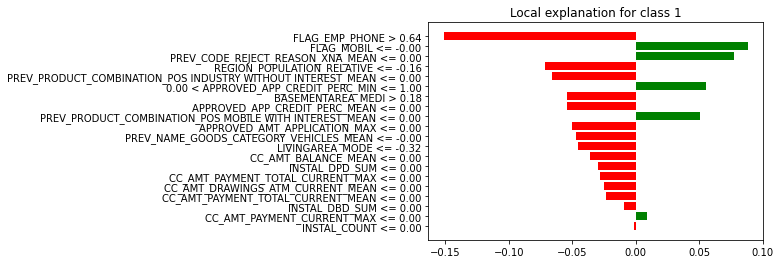

In [163]:
exp.as_pyplot_figure();

In [164]:
del explainer, exp

## Courbe d'apprentissage

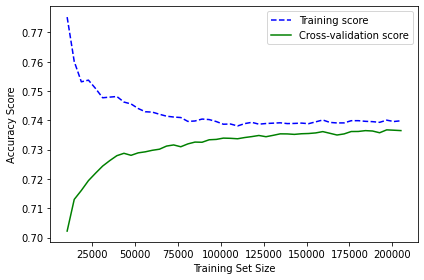

In [166]:
cv = StratifiedKFold(n_splits = 3)
sizes, training_scores, testing_scores = learning_curve(pipeline_final
                                                        , X[listVarKeep]
                                                        , y
                                                        , cv = cv
                                                        , scoring = 'roc_auc'
                                                        , train_sizes = np.linspace(0.01, 1.0, 50)
                                                       ) 

mean_training = np.mean(training_scores, axis = 1) 
Standard_Deviation_training = np.std(training_scores, axis = 1) 
  
mean_testing = np.mean(testing_scores, axis = 1) 
Standard_Deviation_testing = np.std(testing_scores, axis = 1) 

plt.plot(sizes, mean_training, '--', color = "b",  label = "Training score") 
plt.plot(sizes, mean_testing, color = "g", label = "Cross-validation score") 
plt.xlabel("Training Set Size"), plt.ylabel("Roc Auc"), plt.legend(loc = "best") 
plt.tight_layout() 
plt.show();

# Exportation des données et du modèle

## Exportation de l'explainer

In [150]:
X_trans = pipeline_final.steps[0][1].transform(X[listVarKeep])
explainer = LimeTabularExplainer(X_trans
                                  , mode = "classification"
                                  , class_names = class_names
                                  , feature_names = listVarKeep
                                  , categorical_features = listVarKeepCat
                                 )

with gzip.GzipFile('API/dataviz/explainer', 'wb') as f:
            dill.dump(explainer, f)

del explainer

## Sérialisation du modèle

In [151]:
# entrainement sur tout application_train.csv
pipeline_final.fit(X[listVarKeep],y)

# sérialiser le modèle dans un fichier
with bz2.BZ2File('API/dataviz/classifier.pkl', 'wb') as f:
            pickle.dump(pipeline_final, f)

del pipeline_best, pipeline_final

## Modification data_test

In [10]:
df_test = pd.read_csv('API/dataviz/data_test.csv', compression = "bz2")
df_test = df_test[['SK_ID_CURR']+listVarKeep]
df_test.to_csv('API/dataviz/data_test.csv', index = False, compression = 'bz2')
df_test.to_csv('dashboard/data/data_test.csv', index = False, compression = 'bz2')
del df_test, listVarKeep